## Predecir el coste del seguro médico de una persona
La importante compañía de seguros 4Geeks Insurance S.L. quiere calcular, en función de datos los fisiológicos de sus clientes, cuál va a ser la prima (coste) que debe asumir cada uno de ellos. Para ello, ha reunido a un equipo completo de médicos y en función de datos de otras compañías y un estudio particular han logrado reunir un conjunto de datos para entrenar un modelo predictivo.

## Contenido del proyecto
### EDA
* [0. Importar librerias](#c0)
* [1. Cargar el conjunto de datos](#c1)
* [2. Limpieza de datos](#c2)
    * [2.1 Identificar las variables](#s21)
    * [2.2 Identificar duplicados y valores nulos](#s22)
    * [2.3 Eliminar información irrelevante](#s23)
* [3. Análisis Univariante](#c3)
    * [3.1 Análisis categórico](#s31)
    * [3.2 Análisis numérico](#s32) 
* [4. Análisis Multivariante](#c4)
    * [4.1 Análisis Categórico-Categórico](#s41)
    * [4.2 Análisis Numérico-Numérico](#s42)
    * [4.3 Combinaciones de clase con predictoras](#s43)
    * [4.4 Análisis de correlaciones](#s44)
* [5. Ingeniería de características](#c5)
    * [5.1 Valores atípicos](#s51)
    * [5.2 Análisis de valores faltantes](#s52)
* [6. Escalado de valores](#c6)
    * [6.1 Normalización](#s61)
    * [6.2 Escalado Min-Max](#s62)
### Machine Learning 
* [7.1 Regresión logística](#s71)
* [7.2 Optimización de hiperparámetros](#s72)

### 0. Importar librerías

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

import json
from pickle import dump

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet

import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

### 1. Cargar el conjunto de datos

In [2]:
total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv")
total_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### 2. Limpieza de datos

#### 2.1 Identificar las variables

- ***age***. Edad del beneficiario principal (numérico)
- ***sex***. Género del beneficiario principal (categórico)
- ***bmi***. índice de masa corporal (numérico)
- ***children***. Número de niños/dependientes cubiertos por un seguro médico (numérico)
- ***smoker***. ¿Es fumador? (categórico)
- ***region***. Área residencial del beneficiario en USA: noreste, sureste, suroeste, noroeste (categórico)
- ***charges***. Prima del seguro médico. Será nuestra TARGET (numérico)

#### 2.2 Identificar duplicados y valores nulos

In [3]:
total_data_n = total_data.drop_duplicates()
print ("Antes:", total_data.shape)
print ("Después:", total_data_n.shape)

Antes: (1338, 7)
Después: (1337, 7)


Existía un valor duplicado.

In [4]:
total_data_n.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


No existe ningún valor nulo.

### 2.3 Eliminar información irrelevante

En este caso, no vamos a prescindir de ningun valor del DataSet.

### 3. Análisis Univariante

#### 3.1 Análisis Categórico

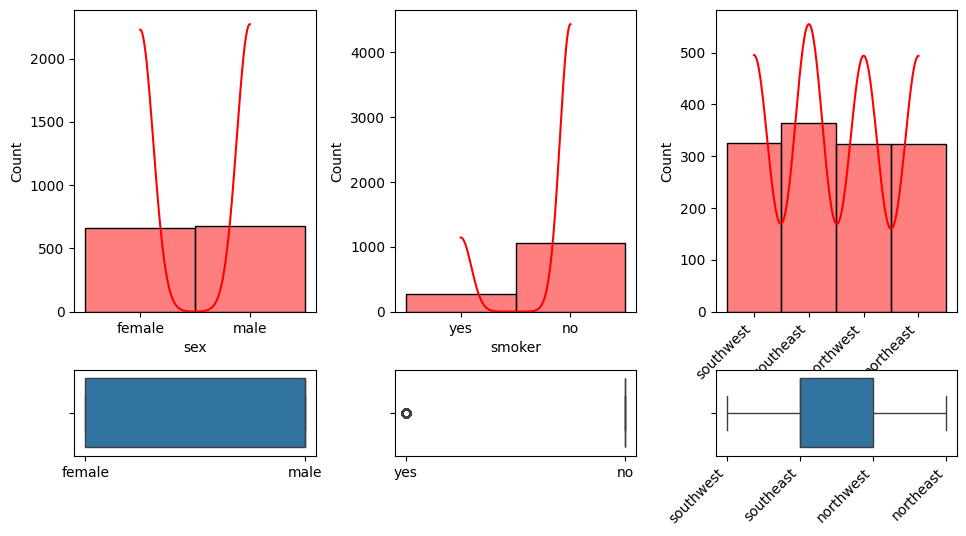

In [5]:
fig, axis = plt.subplots(2, 3, figsize=(10, 5), gridspec_kw={'height_ratios': [7, 2]})

sns.histplot(ax = axis[0,0], data = total_data_n, x = 'sex', kde = True, color = 'red')
sns.boxplot(ax = axis[1,0], data = total_data_n, x = 'sex').set(xlabel = None)

sns.histplot(ax = axis[0,1], data = total_data_n, x = 'smoker', kde = True, color = 'red')
sns.boxplot(ax = axis[1,1], data = total_data_n, x = 'smoker').set(xlabel = None)

sns.histplot(ax = axis[0,2], data = total_data_n, x = 'region', kde = True, color = 'red')
sns.boxplot(ax = axis[1,2], data = total_data_n, x = 'region').set(xlabel = None)

plt.tight_layout()
plt.setp(axis[0,2].get_xticklabels(), rotation=45, ha='right')
plt.setp(axis[1,2].get_xticklabels(), rotation=45, ha='right')
plt.show()


- ***sex***: Hay practicamente el mismo porcentaje de hombres que de mujeres.
- ***smoker***: Destaca la gente que no fuma por encima de la que sí lo hace por una gran diferencia.
- ***region***: Se divide en Noreste, Noroeste, Sureste y Suroeste, y destaca por muy poco Sureste, estando las otras tres regiones a la par.

#### 3.2 Análisis Numérico

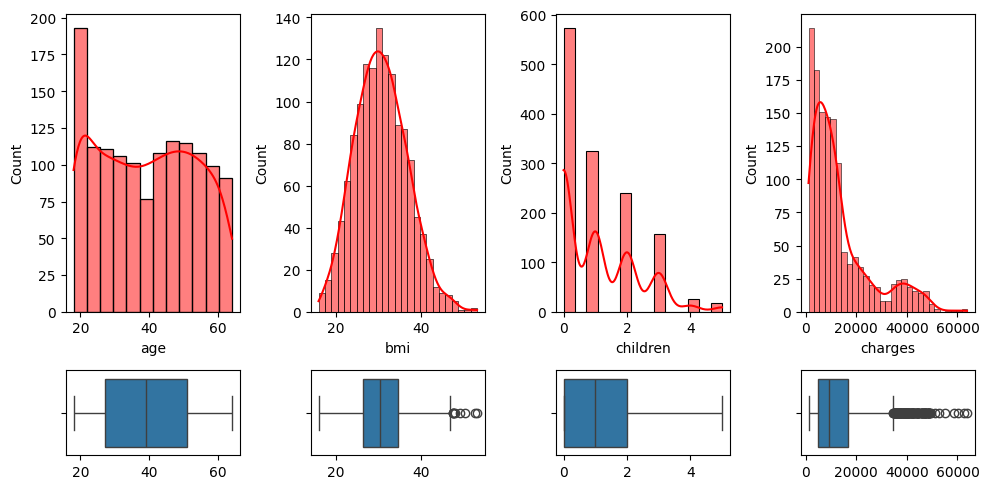

In [6]:
fig, axis = plt.subplots(2, 4, figsize=(10, 5), gridspec_kw={'height_ratios': [7, 2]})

sns.histplot(ax = axis[0,0], data = total_data_n, x = 'age', kde = True, color = 'red')
sns.boxplot(ax = axis[1,0], data = total_data_n, x = 'age').set(xlabel = None)

sns.histplot(ax = axis[0,1], data = total_data_n, x = 'bmi', kde = True, color = 'red')
sns.boxplot(ax = axis[1,1], data = total_data_n, x = 'bmi').set(xlabel = None)

sns.histplot(ax = axis[0,2], data = total_data_n, x = 'children', kde = True, color = 'red')
sns.boxplot(ax = axis[1,2], data = total_data_n, x = 'children').set(xlabel = None)

sns.histplot(ax = axis[0,3], data = total_data_n, x = 'charges', kde = True, color = 'red')
sns.boxplot(ax = axis[1,3], data = total_data_n, x = 'charges').set(xlabel = None)

plt.tight_layout()
plt.show()

- ***age***: Destaca sobretodo la edad de 20 años por encima del resto, siendo muy equivalentes las demás.
- ***bmi***: el indice de masa corporal que más destaca se mueve entre el 28% y el 32%, siendo como una pirámide con valores que se mueven entre aproximadamente un 16% y un 50%.
- ***children***: lo más común es no tener ningún niño cubierto por seguro médico, que seguramente signifique que estas personas no tienen ningún hijo. Va en orden descendente hasta los 5 hijos.
- ***charges***: la prima del seguro médico que más destaca por encima del resto es la menor que hay, siguiendo un orden descendente en su mayoría hasta la máxima registrada.

### 4. Análisis Multivariante

#### 4.1 Análisis Categórico-Categórico

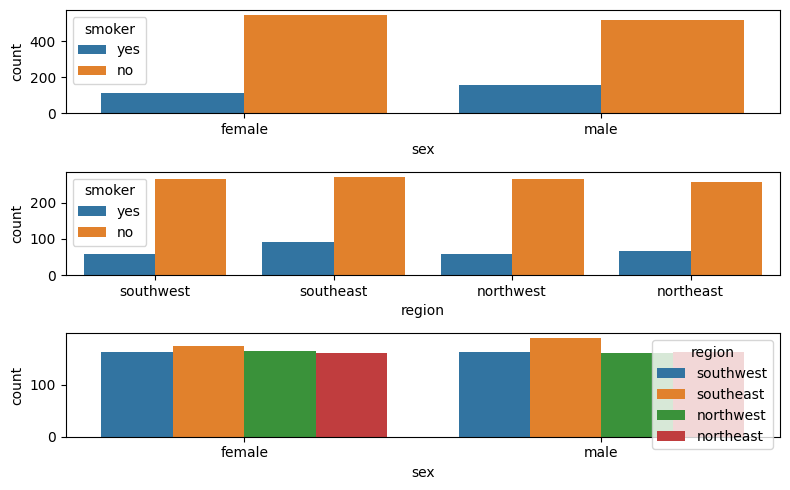

In [8]:
fig, axis = plt.subplots(3, figsize = (8, 5))

sns.countplot(ax = axis[0], data = total_data, x = "sex", hue = "smoker")
sns.countplot(ax = axis[1], data = total_data, x = "region", hue = "smoker")
sns.countplot(ax = axis[2], data = total_data, x = "sex", hue = "region")
plt.tight_layout()

plt.show()

No se ve ninguna relación entre estos tres grupos de datos.